# Train Your Own Model and Serve It With TensorFlow Serving

In this notebook, you will train a neural network to classify images of handwritten digits from the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. You will then save the trained model, and serve it using [TensorFlow Serving](https://www.tensorflow.org/tfx/guide/serving).

## Setup

In [1]:
try:
    %tensorflow_version 2.x
except:
    pass

In [2]:
import os
import json
import tempfile
import requests
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

print("\u2022 Using TensorFlow Version:", tf.__version__)

• Using TensorFlow Version: 2.0.0


## Import the MNIST Dataset

The [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains 70,000 grayscale images of the digits 0 through 9. The images show individual digits at a low resolution (28 by 28 pixels). 

Even though these are really images, we will load them as NumPy arrays and not as binary image objects.

In [3]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [4]:
# EXERCISE: Scale the values of the arrays below to be between 0.0 and 1.0.
train_images = train_images / 255.0
test_images = test_images / 255.0

In the cell below use the `.reshape` method to resize the arrays to the following sizes:

```python
train_images.shape: (60000, 28, 28, 1)
test_images.shape: (10000, 28, 28, 1)
```

In [5]:
# EXERCISE: Reshape the arrays below.
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

In [6]:
print('\ntrain_images.shape: {}, of {}'.format(train_images.shape, train_images.dtype))
print('test_images.shape: {}, of {}'.format(test_images.shape, test_images.dtype))


train_images.shape: (60000, 28, 28, 1), of float64
test_images.shape: (10000, 28, 28, 1), of float64


## Look at a Sample Image

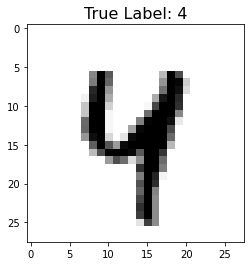

In [7]:
idx = 42

plt.imshow(test_images[idx].reshape(28,28), cmap=plt.cm.binary)
plt.title('True Label: {}'.format(test_labels[idx]), fontdict={'size': 16})
plt.show()

## Build a Model

In the cell below build a `tf.keras.Sequential` model that can be used to classify the images of the MNIST dataset. Feel free to use the simplest possible CNN. Make sure your model has the correct `input_shape` and the correct number of output units.

In [8]:
# EXERCISE: Create a model.
model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(input_shape=(28,28,1), filters=8, kernel_size=3, strides=2, activation='relu', name='Conv1'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax, name='Softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 13, 13, 8)         80        
_________________________________________________________________
flatten (Flatten)            (None, 1352)              0         
_________________________________________________________________
Softmax (Dense)              (None, 10)                13530     
Total params: 13,610
Trainable params: 13,610
Non-trainable params: 0
_________________________________________________________________


## Train the Model

In the cell below configure your model for training using the `adam` optimizer, `sparse_categorical_crossentropy` as the loss, and `accuracy` for your metrics. Then train the model for the given number of epochs, using the `train_images` array.

In [9]:
# EXERCISE: Configure the model for training.
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

epochs = 5

# EXERCISE: Train the model.
history = model.fit(train_images, train_labels, epochs=epochs)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 3s 55us/sample - loss: 0.3774 - accuracy: 0.8955
Epoch 2/5
60000/60000 [==============================] - 2s 39us/sample - loss: 0.2213 - accuracy: 0.9381
Epoch 3/5
60000/60000 [==============================] - 2s 39us/sample - loss: 0.1694 - accuracy: 0.9522
Epoch 4/5
60000/60000 [==============================] - 2s 38us/sample - loss: 0.1401 - accuracy: 0.9604
Epoch 5/5
60000/60000 [==============================] - 2s 39us/sample - loss: 0.1218 - accuracy: 0.9649


## Evaluate the Model

In [10]:
# EXERCISE: Evaluate the model on the test images.
results_eval = model.evaluate(test_images, test_labels, verbose=0)

for metric, value in zip(model.metrics_names, results_eval):
    print(metric + ': {:.3}'.format(value))

loss: 0.114
accuracy: 0.966


## Save the Model

In [11]:
MODEL_DIR = tempfile.gettempdir()

version = 1

export_path = os.path.join(MODEL_DIR, str(version))

if os.path.isdir(export_path):
    print('\nAlready saved a model, cleaning up\n')
    !rm -r {export_path}

model.save(export_path, save_format="tf")

print('\nexport_path = {}'.format(export_path))
!ls -l {export_path}


Already saved a model, cleaning up

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /tmp/1/assets

export_path = /tmp/1
total 80
drwxr-xr-x 2 pedro pedro  4096 Feb  6 18:29 assets
-rw-rw-r-- 1 pedro pedro 73427 Feb  6 18:29 saved_model.pb
drwxr-xr-x 2 pedro pedro  4096 Feb  6 18:29 variables


## Examine Your Saved Model

In [12]:
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['Conv1_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 28, 28, 1)
        name: serving_default_Conv1_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['Softmax'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict


## Add TensorFlow Serving Distribution URI as a Package Source

In [ ]:
# This is the same as you would do from your command line, but without the [arch=amd64], and no sudo
# You would instead do:
echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -

## Install TensorFlow Serving

In [ ]:
!apt update
!apt-get install tensorflow-model-server

## Run the TensorFlow Model Server

You will now launch the TensorFlow model server with a bash script. In the cell below use the following parameters when running the TensorFlow model server:

* `rest_api_port`: Use port `8501` for your requests.


* `model_name`: Use `digits_model` as your model name. 


* `model_base_path`: Use the environment variable `MODEL_DIR` defined below as the base path to the saved model.

In [13]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [18]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=digits_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

In [19]:
!tail server.log

To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-02-06 18:31:08.964663: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:206] Restoring SavedModel bundle.
2021-02-06 18:31:08.982397: I external/org_tensorflow/tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3999980000 Hz
2021-02-06 18:31:09.002110: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:190] Running initialization op on SavedModel bundle at path: /tmp/1
2021-02-06 18:31:09.004880: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:277] SavedModel load for tags { serve }; Status: success: OK. Took 94418 microseconds.
2021-02-06 18:31:09.005202: I tensorflow_serving/servables/tensorflow/saved_model_warmup_util.cc:59] No warmup data file found at /tmp/1/assets.extra/tf_serving_warmup_requests
2021-02-06 18:31:09.005398: I tensorflow_serving/core/loader_harness.cc:87] Successfully loaded servable version {name: digits_model

## Create JSON Object with Test Images

In the cell below construct a JSON object and use the first three images of the testing set (`test_images`) as your data.

In [20]:
# EXERCISE: Create JSON Object
data = json.dumps({"signature_name": "serving_default", "instances": test_images[0:3].tolist()})

## Make Inference Request

In the cell below, send a predict request as a POST to the server's REST endpoint, and pass it your test data. You should ask the server to give you the latest version of your model.

In [21]:
# EXERCISE: Fill in the code below
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/digits_model:predict', 
                              data=data, headers=headers)

predictions = json.loads(json_response.text)['predictions']

## Plot Predictions

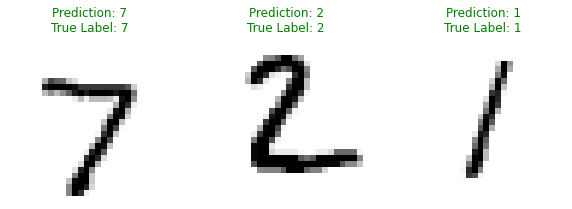

In [22]:
plt.figure(figsize=(10,15))

for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(test_images[i].reshape(28,28), cmap = plt.cm.binary)
    plt.axis('off')
    color = 'green' if np.argmax(predictions[i]) == test_labels[i] else 'red'
    plt.title('Prediction: {}\nTrue Label: {}'.format(np.argmax(predictions[i]), test_labels[i]), color=color)
    
plt.show()